Colas Drutinus--Cabin

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">LightGBM</div>

LightGBM (short for Light Gradient Boosting Machine) is a gradient boosting method, originally developed by Microsoft, based on decision trees. This notebook will present you this technique and help you to compare it with classic gradient boosting methods such as XGBoost. 


1. [LightGBM](#sec1)
    1. [Gradient-based One-Side Sampling](#sec1-1)
    2. [Exclusive Feature Bundling](#sec1-2)
2. [LightGBM in Python API](#sec2)
3. [Examples](#sec3)
    1. [NIST](#sec3-1)
    2. [Wine](#sec3-2)
4. [LightGBM vs XGBoost](#sec4)
    1. [Data Analysis](#sec4-1)
    2. [Classification](#sec4-2)

Please install the following librairies in order to work on the notebook.
The first ones are the LightGBM and XGBoost librairies, and the last one allows to use widgets for interactive plots.

In [1]:
#pip install lightgbm
#pip install xgboost
#pip install ipywidgets

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import numpy as np
import pandas as pd
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import lightgbm as lgb
import xgboost as xgb

# interactive widgets
try:
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

# <a id="sec1"></a> 1. LightGBM


Gradient Boosting Decision Tree (GBDT) is a popular technique in Machine Learning whose efficiency has been verified by winning several ML competitions. However, its efficiency and scalability are still not enough when the number of data, or the number of features become high.

To rectify this, two new techniques are presented by [[1]](#source1) : Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB). The implementation of GBDT with GOSS and EFB is called LightGBM (short for Light Gradient Boosting Machine). 

LightGBM is therefore an improved GDBT method, just like XGBoost, but we will see that in can be much faster, especially with large amout of data.

#### LightGBM vs XGBoost

The main difference between LightGBM and XGBoost lies in the way trees are constructed. Indeed, LightGBM does not grow a tree level-wise, but leaf-wise. It chooses the leaf which will yield the largest decrease in loss. [[2]](#source2)

The main cost in GBDT lies in learning the decision trees, and the most time-consuming part in learning a decision tree is to find the best split points. In order to find split points, LightGBM uses the histogram-based algorithm which buckets continuous feature values into discrete bins and uses these bins to construct feature histograms during training. This algorithm is more efficient than the pre-sorted algorithm, which enumerates all possible split points on the pre-sorted
feature values, and is used by XGBoost.

## <a id="sec1-1"></a>  A. Gradient-based One-Side Sampling (GOSS)

This novel sampling method for GBDT was created to achieve a good balance between reducing the number of data instances and keeping the accuracy for learned decision trees.

For instances associated with small gradients, the training error  is small and it is already well-trained. The straightforward idea is to discard those data instances with small gradients. That is why GOSS keeps all the instances with large gradients and performs random sampling on the instances with small gradients.

Specifically, GOSS firstly sorts the data instances according to the absolute value of their gradients and selects the top $a \times 100 \%$ instances. 

Then it randomly samples $b \times 100 \%$ instances from the rest of the data. 

After that, GOSS amplifies the sampled data with small gradients by a constant $\frac{1-a}{b}$ when calculating the information gain. By doing so, we put more focus on the under-trained instances without changing the original data distribution by much.

This sampling method therefore reduces the number of data instances and improves the speed of the training.

## <a id="sec1-2"></a>  B. Exclusive Feature Bundling (EFB)

The main idea behind EFB is that high-dimensional data are usually very sparse, and therefore many features are mutually exclusive, i.e., they never take nonzero values simultaneously. 

We can safely bundle exclusive features into a single feature (which we call an exclusive feature bundle) and then build the same feature histograms from the feature bundles as those from individual features. This allows to avoid unnecessary computation for zero feature values, and reduce a lot the complexity of histogram building : from $O(\#data \times \#feature)$ to $O(\#data \times \#bundle)$

Then we can significantly speed up the training of GBDT without hurting the accuracy.

# <a id="sec2"></a>  2. LightGBM in Python API

To use LightGBM, we will use the python librairy "lightgbm".

Let's begin with a simple binary classification task.

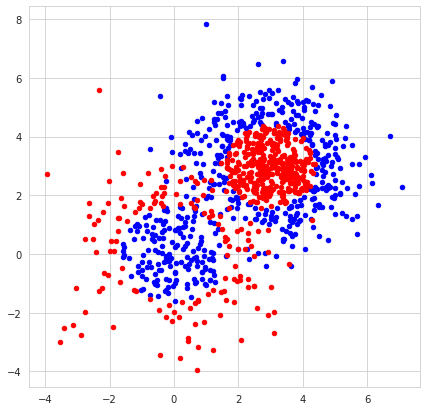

In [3]:
from sklearn import datasets

X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(7,7))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)

We first split the data into a training and a test datasets. We will then train the LGBM Classifier to classify the data.

The parameter "early_stopping_rounds" ($n$) allows us to tune the number of trees we are going to use. It makes the training stop when it hasn't improved during $n$ rounds.

In [4]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 500,
                       objective='binary')

metrics = ['binary_logloss','auc']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 10,
          verbose = 10,
          feature_name = ['X','Y'])

Training until validation scores don't improve for 10 rounds
[10]	Training data's binary_logloss: 0.392589	Training data's auc: 0.949376	Test data's binary_logloss: 0.441358	Test data's auc: 0.909455
[20]	Training data's binary_logloss: 0.29271	Training data's auc: 0.971413	Test data's binary_logloss: 0.354777	Test data's auc: 0.938301
[30]	Training data's binary_logloss: 0.240247	Training data's auc: 0.981067	Test data's binary_logloss: 0.308517	Test data's auc: 0.947566
[40]	Training data's binary_logloss: 0.206535	Training data's auc: 0.986164	Test data's binary_logloss: 0.282898	Test data's auc: 0.954127
[50]	Training data's binary_logloss: 0.182597	Training data's auc: 0.988696	Test data's binary_logloss: 0.266146	Test data's auc: 0.957332
[60]	Training data's binary_logloss: 0.164051	Training data's auc: 0.991096	Test data's binary_logloss: 0.256473	Test data's auc: 0.960036
[70]	Training data's binary_logloss: 0.148392	Training data's auc: 0.992393	Test data's binary_logloss: 0.

LGBMClassifier(max_depth=4, n_estimators=500, num_leaves=7, objective='binary')

An interactive plot of the metrics.

In [5]:
def render_metric(metric_name):
    ax = lgb.plot_metric(model.evals_result_, metric=metric_name, figsize=(10, 5))
    plt.show()
    
def plot_metrics():
    if INTERACTIVE:
        # create widget to switch between metrics
        interact(render_metric, metric_name=metrics)
    else:
        for metric in metrics:
            render_metric(metric)

In [6]:
plot_metrics()

interactive(children=(Dropdown(description='metric_name', options=('binary_logloss', 'auc'), value='binary_log…

We can see that the accuracy is quite good, even for the testing sample. We will check the predictions with the confusion matrix.

<div class="alert alert-warning">
    
**Exercice:**<br>
Your turn to play. Check the predictions with the confusion matrix.
</div>

In [35]:
# %load solutions/code.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

Let's now plot the decision boudaries.

In [13]:
def plot_decision_boundary(model, X, y, fig_size=(7,7)):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = model.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure(figsize=fig_size)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = model.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b',s=20)
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v',s=20)
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r',s=20)
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v',s=20)
    plt.show()

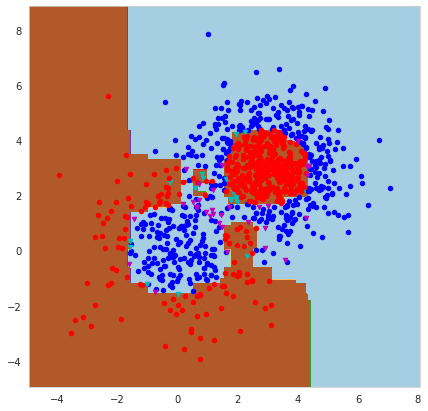

In [14]:
plot_decision_boundary(model,X,y)

Finally, we will plot the decision trees.

In [15]:
def render_tree(tree_index, show_info, precision=3):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(model, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

def plot_trees():
    if INTERACTIVE:
        # create widget to switch between trees and control info in nodes
        interact(render_tree,
                 tree_index=(0, model.best_iteration_ - 1),
                 show_info=SelectMultiple(  # allow multiple values to be selected
                     options=['None',
                              'split_gain',
                              'internal_count',
                              'data_percentage'],
                     value=['None']),
                 precision=(0, 4))
        tree = None
    else:
        tree = render_tree(2, ['None'])
    
    tree

In [16]:
plot_trees()

interactive(children=(IntSlider(value=39, description='tree_index', max=79), SelectMultiple(description='show_…

# <a id="sec3"></a>  3. Examples

## <a id="sec3-1"></a>  A. NIST

In [17]:
digits = datasets.load_digits()
#print(digits.DESCR)

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [18]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.440566	Test data's multi_logloss: 0.584513
[20]	Training data's multi_logloss: 0.139353	Test data's multi_logloss: 0.302181
[30]	Training data's multi_logloss: 0.0506598	Test data's multi_logloss: 0.203133
[40]	Training data's multi_logloss: 0.0194933	Test data's multi_logloss: 0.159028
[50]	Training data's multi_logloss: 0.00797996	Test data's multi_logloss: 0.144219
[60]	Training data's multi_logloss: 0.00335128	Test data's multi_logloss: 0.138814
[70]	Training data's multi_logloss: 0.00146285	Test data's multi_logloss: 0.131636
[80]	Training data's multi_logloss: 0.000649036	Test data's multi_logloss: 0.125946
[90]	Training data's multi_logloss: 0.000291306	Test data's multi_logloss: 0.121407
Early stopping, best iteration is:
[85]	Training data's multi_logloss: 0.000429679	Test data's multi_logloss: 0.119559


LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [19]:
plot_metrics()
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Generalization score : 0.953


## <a id="sec3-2"></a>  A. Wine

In [20]:
wine = datasets.load_wine()
#print(wine.DESCR)

X = wine.data
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [21]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.325115	Test data's multi_logloss: 0.423244
[20]	Training data's multi_logloss: 0.12443	Test data's multi_logloss: 0.194634
[30]	Training data's multi_logloss: 0.0497734	Test data's multi_logloss: 0.114617
[40]	Training data's multi_logloss: 0.0195755	Test data's multi_logloss: 0.0950695
Early stopping, best iteration is:
[38]	Training data's multi_logloss: 0.0237515	Test data's multi_logloss: 0.0939949


LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [22]:
plot_metrics()
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Generalization score : 0.956


# <a id="sec4"></a>  4. LightGBM vs XGBoost

### A complete exemple : Classification of stars, Galaxies, Quasars

This example, notably the pre-processing of the data, is taken from the notebook about XGBoost, which is part of the Machine Learning class by Emmanuel Rachelson.

For this first application of XGBoost, we will try to classify observations of space to be either stars, galaxies or quasars.
We are using data from the [Sloan Digital Sky Survey](http://www.sdss.org/)

#### About the SDSS
The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [23]:
sdss_df = pd.read_csv('./data/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


In [24]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

## <a id="sec4-1"></a> A. Data Analysis

Before applying any classification algorithm, let's look a bit more and transform the data : first we remove the column that obviously won't help classify into the correct class, such as the objects id and parameters of the camera at the moment of observation.

In [25]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


Next we look at a few interesting features (univariate analysis) : by plotting the distribution of each class along this feature, we can estimate if this feature can help in classifying the data.

For instance, we can see that redshift seems to have good correlation, while declination does not differ significantly between the 3 classes.

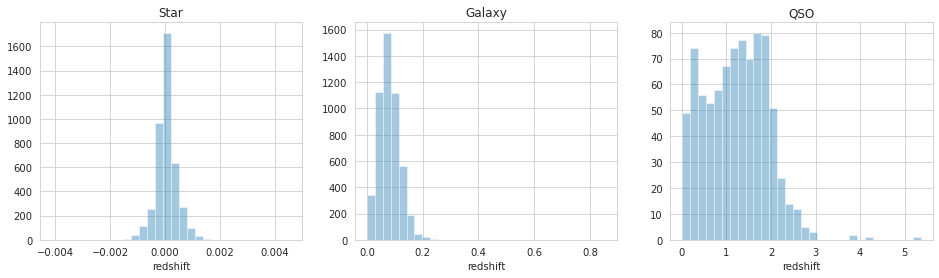

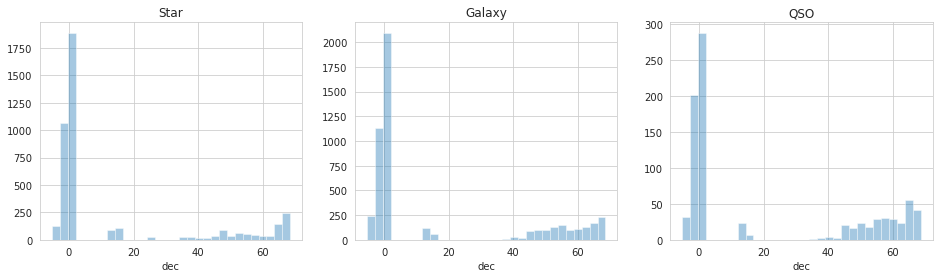

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].dec, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].dec, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].dec, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Finally, we transform a few features : we transform the different bands through a PCA, we encode the classes and scale the extreme values.

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

## <a id="sec4-2"></a> B. Classification

### LightGBM

We will try to tune the parameters of the classificator :

In [29]:
X_train, X_test, y_train, y_test = train_test_split(sdss,y_encoded, test_size=0.2)

In [30]:
from sklearn.model_selection import GridSearchCV

def tune_param(model, rate, estimators):
    
    if model == 'lgb':
        model = LGBMClassifier(boosting_type='gbdt',
                               learning_rate = rate,
                               n_estimators=estimators,
                               objective='multiclass')

        param_test = {
         'num_leaves':[3,5,7,9],
         'max_depth':[3,5,7]
        }
    
    elif model == 'xgb':
        model = XGBClassifier(n_estimators = estimators,
                              learning_rate = rate,
                              objective='multiclass',
                              eval_metric='mlogloss',
                              use_label_encoder=False)

        param_test = {
         'max_depth':[3,5,7],
         'min_child_weight':[1,3,5]
        }
        
    else :
        print("Error : model must be 'lgb' or 'xgb'. ")
        
    gsearch1 = GridSearchCV(estimator = model, param_grid = param_test, cv=10)
    gsearch1.fit(X_train, y_train)
    
    print("Best parameters: ", gsearch1.best_params_)
    print("Best score: ", gsearch1.best_score_)
    
    return gsearch1.best_params_

In [31]:
rate=0.1
estimators=100
best_params = tune_param('lgb', rate, estimators)

Best parameters:  {'max_depth': 5, 'num_leaves': 5}
Best score:  0.991625


In [32]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = best_params['num_leaves'],
                       max_depth = best_params['max_depth'],
                       learning_rate = rate,
                       n_estimators = estimators,
                       objective='multiclass')

metrics = ['multi_logloss']

start = time.time()

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 20,
          verbose = 10)

end = time.time()

Training until validation scores don't improve for 20 rounds
[10]	Training data's multi_logloss: 0.197343	Test data's multi_logloss: 0.198655
[20]	Training data's multi_logloss: 0.0716194	Test data's multi_logloss: 0.0742704
[30]	Training data's multi_logloss: 0.0405509	Test data's multi_logloss: 0.045371
[40]	Training data's multi_logloss: 0.0259656	Test data's multi_logloss: 0.0309831
[50]	Training data's multi_logloss: 0.0202622	Test data's multi_logloss: 0.0285539
[60]	Training data's multi_logloss: 0.0166396	Test data's multi_logloss: 0.0276963
[70]	Training data's multi_logloss: 0.0140082	Test data's multi_logloss: 0.0278397
[80]	Training data's multi_logloss: 0.0122358	Test data's multi_logloss: 0.0280106
Early stopping, best iteration is:
[62]	Training data's multi_logloss: 0.016035	Test data's multi_logloss: 0.02764


In [33]:
plot_metrics()
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))
print('Elapsed time : {}s'.format(round(end-start,3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 0.994
Generalization score : 0.992
Elapsed time : 0.239s


## XGBoost

In [36]:
from xgboost import XGBClassifier

best_params = tune_param('xgb', rate, estimators)

Best parameters:  {'max_depth': 7, 'min_child_weight': 1}
Best score:  0.993375


In [37]:
model = XGBClassifier( min_child_weight = best_params['min_child_weight'],
                       max_depth = best_params['max_depth'],
                       learning_rate = rate,
                       n_estimators = estimators,
                       objective='multiclass')

metrics = ['mlogloss']

start = time.time()

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_metric = metrics,
          early_stopping_rounds = 20,
          verbose = 10)

end = time.time()

[0]	validation_0-mlogloss:0.95685	validation_1-mlogloss:0.95766


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:0.30293	validation_1-mlogloss:0.30946
[20]	validation_0-mlogloss:0.11356	validation_1-mlogloss:0.12260
[30]	validation_0-mlogloss:0.04587	validation_1-mlogloss:0.05539
[40]	validation_0-mlogloss:0.02095	validation_1-mlogloss:0.03174
[50]	validation_0-mlogloss:0.01081	validation_1-mlogloss:0.02386
[60]	validation_0-mlogloss:0.00636	validation_1-mlogloss:0.02178
[70]	validation_0-mlogloss:0.00403	validation_1-mlogloss:0.02162
[80]	validation_0-mlogloss:0.00283	validation_1-mlogloss:0.02183
[83]	validation_0-mlogloss:0.00258	validation_1-mlogloss:0.02192


In [38]:
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))
print('Elapsed time : {}s'.format(round(end-start,3)))

plot_metrics()

Training score : 0.999
Generalization score : 0.996
Elapsed time : 2.023s


interactive(children=(Dropdown(description='metric_name', options=('mlogloss',), value='mlogloss'), Output()),…

When comparing the time elapsed for the training of the model, we can see that the LightGBM model is much faster than the XGBoost one. 

But this time difference is even bigger when the size of the data is larger : according to [[1]](#source1), LightGBM can be 20 times faster than XGBoost. 

Because of the performance of my computer (and certainly yours), I haven't tested with big datasets, but you can try it yourself. Here is the link for the famous [AllState dataset](https://www.kaggle.com/c/allstate-claims-severity/data). 

Parallelize LightGBM is also possible to improve the speed of training : https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html

## Sources:
1. <a id="source1"></a> "LightGBM: A Highly Efficient Gradient Boosting Decision Tree", Guolin Ke, Qi Meng, Thomas Finely, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, Tie-Yan Liu (2017)
2. <a id="source2"></a> [Wikipédia](https://en.wikipedia.org/wiki/LightGBM)

Thank you for following this notebook. Feel free to follow me on [Github](https://github.com/cdrutinus) for more documentation.